### Problem 2: CART-RF-ANN

An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

In [955]:
# Importing all libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('bright')
from warnings import filterwarnings
filterwarnings('ignore')

#### Data Dictionary

1. Target: Claim Status (Claimed)
2. Code of tour firm (Agency_Code)
3. Type of tour insurance firms (Type)
4. Distribution channel of tour insurance agencies (Channel)
5. Name of the tour insurance products (Product)
6. Duration of the tour (Duration in days)
7. Destination of the tour (Destination)
8. Amount worth of sales per customer in procuring tour insurance policies in rupees (in 100’s)
9. The commission received for tour insurance firm (Commission is in percentage of sales)
10.Age of insured (Age)

#### 2.1 Read the data and do exploratory data analysis (4 pts). Describe the data briefly. Interpret the inferences for each (2 pts). Initial steps like head() .info(), Data Types, etc . Null value check. Distribution plots(histogram) or similar plots for the continuous columns. Box plots, Correlation plots. Appropriate plots for categorical variables. Inferences on each plot. Summary stats, Skewness, Outliers proportion should be discussed, and inferences from above used plots should be there. There is no restriction on how the learner wishes to implement this but the code should be able to represent the correct output and inferences should be logical and correct.

In [956]:
# Loading the dataset
df = pd.read_csv('insurance_part2_data-2.csv')

In [957]:
df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [958]:
# checking the rows and columns in the dataset
df.shape

(3000, 10)

In [959]:
# information on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [960]:
# checking for duplicates
print('There are',df.duplicated().sum(),'duplicates in this dataset')

There are 139 duplicates in this dataset


In [961]:
df.describe(percentiles=(0.10,0.25,0.50,0.75,0.95)).T

,count,mean,std,min,10%,25%,50%,75%,95%,max
Age,3000.0,38.091000,10.463518,8.0,26.000,32.0,36.00,42.000,60.000,84.00
Commision,3000.0,14.529203,25.481455,0.0,0.000,0.0,4.63,17.235,63.210,210.21
Duration,3000.0,70.001333,134.053313,-1.0,5.000,11.0,26.50,63.000,367.000,4580.00
Sales,3000.0,60.249913,70.733954,0.0,11.171,20.0,33.00,69.000,228.565,539.00


#### Treating Bad Data

In [962]:
# Let us remove the duplicate rows
df.drop_duplicates(inplace=True)

In [963]:
print('There are',df.duplicated().sum(),'duplicates in this dataset after removing the duplicates')

There are 0 duplicates in this dataset after removing the duplicates


In [964]:
df[df['Duration'] == -1]

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
1508,25,JZI,Airlines,No,6.3,Online,-1,18.0,Bronze Plan,ASIA


From the above we can see that we have one observation in Duration column with value -1 which cannot be the case. Duration of a stay cannot be in negative numbers. Hence let us impute the bad data with mean value 72.14 days.

In [965]:
df['Duration'].mean()

72.12023767913317

In [966]:
df['Duration'] = df['Duration'].replace(to_replace=-1, value=df['Duration'].mean())

In [967]:
df.loc[1508]

Age                      25
Agency_Code             JZI
Type               Airlines
Claimed                  No
Commision               6.3
Channel              Online
Duration          72.120238
Sales                  18.0
Product Name    Bronze Plan
Destination            ASIA
Name: 1508, dtype: object

Let us segregate the data into numerical and categorical dataframes

In [968]:
df_with_outliers = df

In [969]:
df_numerical = df[['Age', 'Duration', 'Commision', 'Sales']]
df_numerical.head()

,Age,Duration,Commision,Sales
0,48,7.0,0.70,2.51
1,36,34.0,0.00,20.00
2,39,3.0,5.94,9.90
3,36,4.0,0.00,26.00
4,33,53.0,6.30,18.00


In [970]:
df_categorical = df[['Agency_Code', 'Type', 'Claimed', 'Channel', 'Product Name', 'Destination']]
df_categorical.head()

,Agency_Code,Type,Claimed,Channel,Product Name,Destination
0,C2B,Airlines,No,Online,Customised Plan,ASIA
1,EPX,Travel Agency,No,Online,Customised Plan,ASIA
2,CWT,Travel Agency,No,Online,Customised Plan,Americas
3,EPX,Travel Agency,No,Online,Cancellation Plan,ASIA
4,JZI,Airlines,No,Online,Bronze Plan,ASIA


In [971]:
df_categorical['Claimed'].value_counts()

No     1947
Yes     914
Name: Claimed, dtype: int64

### Univariate Analysis

#### Boxplots

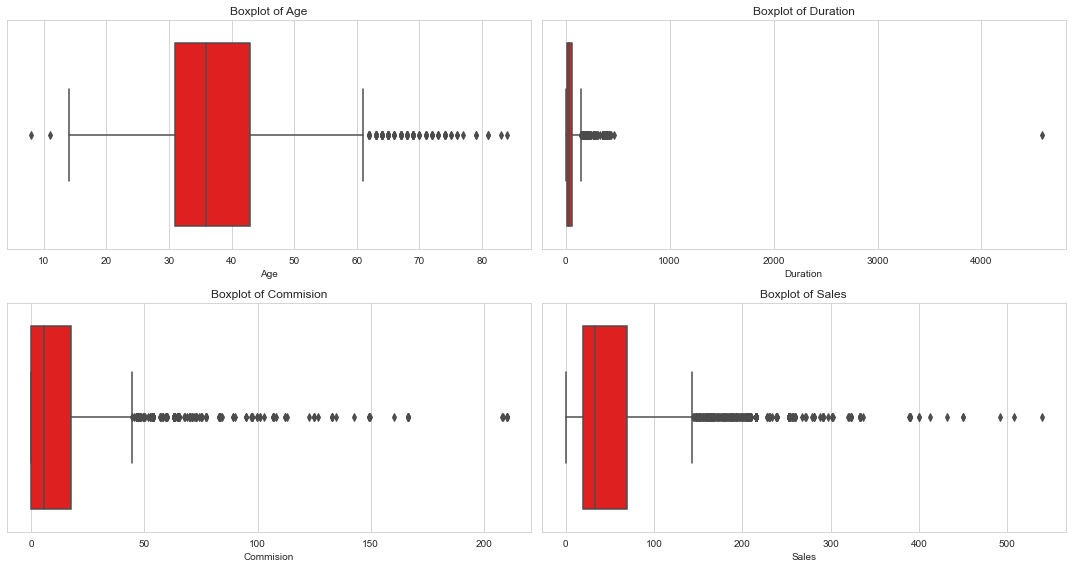

In [972]:
plt.figure(figsize = (15,8))
feature_list = df_numerical.columns
for i in range(len(feature_list)):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df_numerical[feature_list[i]], data=df_numerical, orient='h', color='r')
    plt.title('Boxplot of {}'.format(feature_list[i]))
    plt.tight_layout()

In [973]:
from scipy.stats import norm

#### Distribution Plots

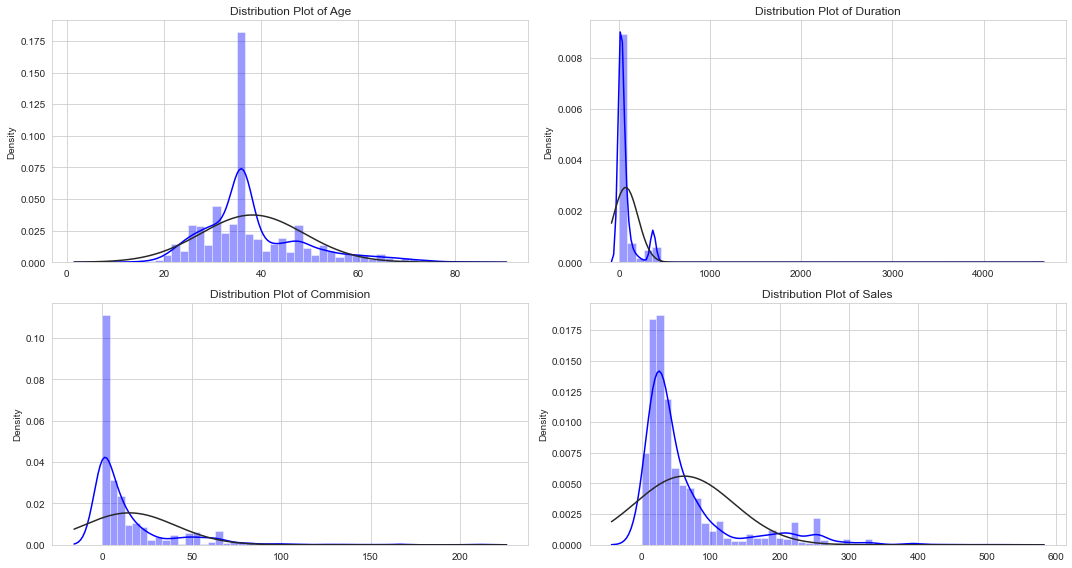

In [974]:
plt.figure(figsize = (15,8))
feature_list = df_numerical.columns
for i in range(len(feature_list)):
    plt.subplot(2,2,i+1)
    sns.distplot(x=df_numerical[feature_list[i]], color='b', fit=norm)
    plt.title('Distribution Plot of {}'.format(feature_list[i]))
    plt.tight_layout()

#### Skewness and Kurtosis

In [975]:
for columns in df_numerical.columns:
    print('Skewness of {} is'.format(columns), round(df_numerical[columns].skew(),2))
    print('Kurtosis of {} is'.format(columns), round(df_numerical[columns].kurt(),2))

Skewness of Age is 1.1
Kurtosis of Age is 1.44
Skewness of Duration is 13.79
Kurtosis of Duration is 422.71
Skewness of Commision is 3.1
Kurtosis of Commision is 13.59
Skewness of Sales is 2.34
Kurtosis of Sales is 5.97


### Bivariate Analysis

#### Plotting numerical variables w.r.t Claimed status

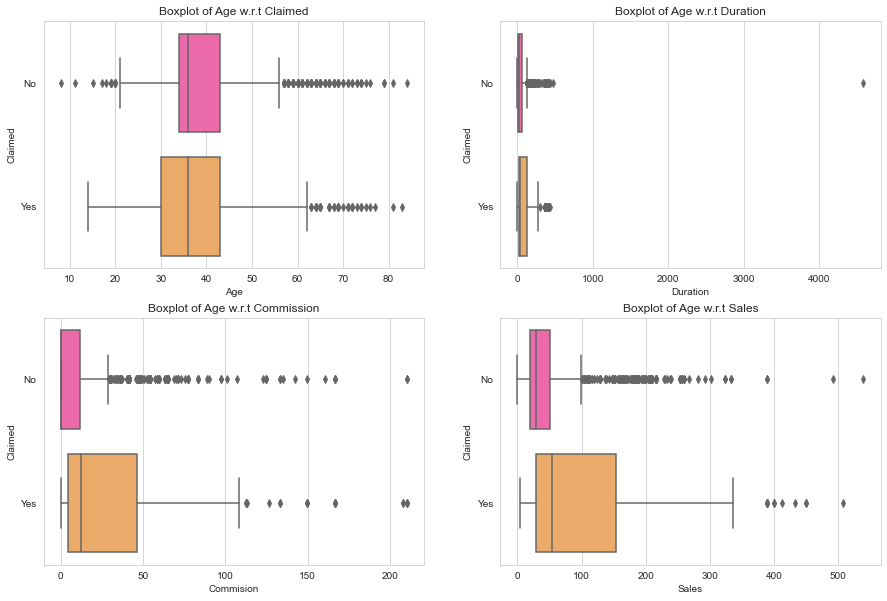

In [976]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.boxplot(y='Claimed', x='Age', data=df, palette='spring')
plt.title('Boxplot of Age w.r.t Claimed')

plt.subplot(2,2,2)
sns.boxplot(y='Claimed', x='Duration', data=df, palette='spring')
plt.title('Boxplot of Age w.r.t Duration')

plt.subplot(2,2,3)
sns.boxplot(y='Claimed', x='Commision', data=df, palette='spring')
plt.title('Boxplot of Age w.r.t Commission')

plt.subplot(2,2,4)
sns.boxplot(y='Claimed', x='Sales', data=df, palette='spring')
plt.title('Boxplot of Age w.r.t Sales');

#### Plotting Age with categorical variables w.r.t Claimed status

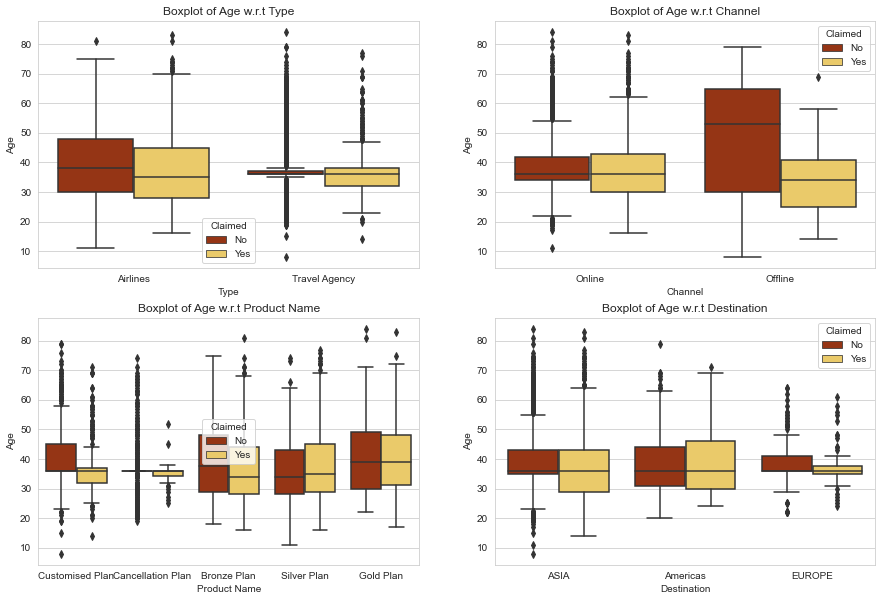

In [977]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.boxplot(y='Age', x='Type', hue='Claimed', data=df, palette='afmhot')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Age w.r.t Type')

plt.subplot(2,2,2)
sns.boxplot(y='Age', x='Channel', hue='Claimed', data=df, palette='afmhot')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Age w.r.t Channel')

plt.subplot(2,2,3)
sns.boxplot(y='Age', x='Product Name', hue='Claimed', data=df, palette='afmhot')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Age w.r.t Product Name');

plt.subplot(2,2,4)
sns.boxplot(y='Age', x='Destination', hue='Claimed', data=df, palette='afmhot')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Age w.r.t Destination');

#### Plotting Commission with categorical variables w.r.t Claimed status

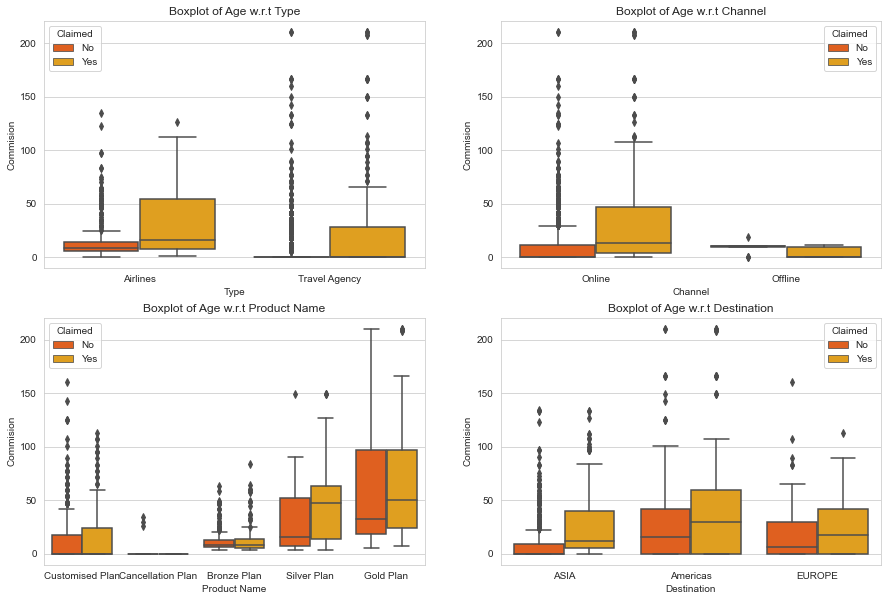

In [978]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.boxplot(y='Commision', x='Type', hue='Claimed', data=df, palette='autumn')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Age w.r.t Type')

plt.subplot(2,2,2)
sns.boxplot(y='Commision', x='Channel', hue='Claimed', data=df, palette='autumn')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Age w.r.t Channel')

plt.subplot(2,2,3)
sns.boxplot(y='Commision', x='Product Name', hue='Claimed', data=df, palette='autumn')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Age w.r.t Product Name');

plt.subplot(2,2,4)
sns.boxplot(y='Commision', x='Destination', hue='Claimed', data=df, palette='autumn')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Age w.r.t Destination');

#### Plotting Duration with categorical variables w.r.t Claimed status

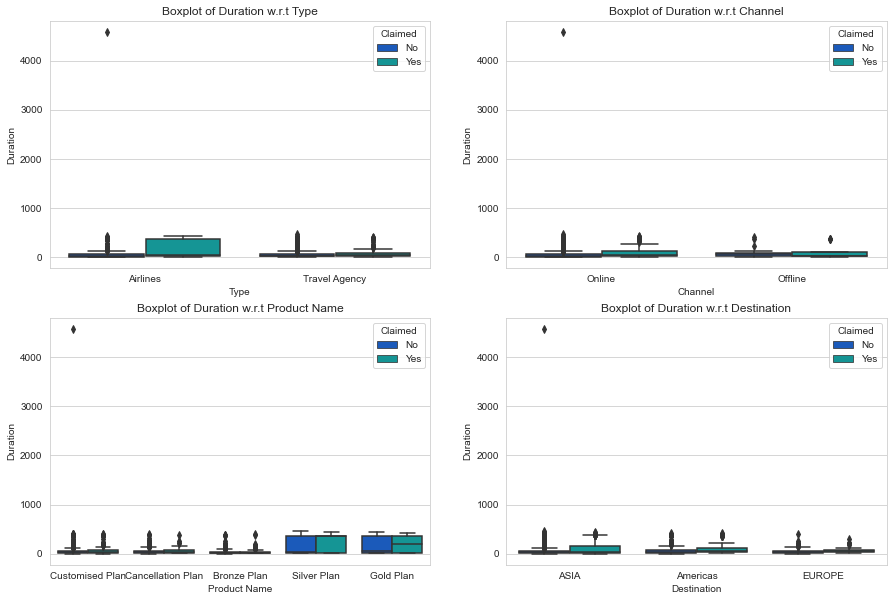

In [979]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.boxplot(y='Duration', x='Type', hue='Claimed', data=df, palette='winter')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Duration w.r.t Type')

plt.subplot(2,2,2)
sns.boxplot(y='Duration', x='Channel', hue='Claimed', data=df, palette='winter')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Duration w.r.t Channel')

plt.subplot(2,2,3)
sns.boxplot(y='Duration', x='Product Name', hue='Claimed', data=df, palette='winter')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Duration w.r.t Product Name');

plt.subplot(2,2,4)
sns.boxplot(y='Duration', x='Destination', hue='Claimed', data=df, palette='winter')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Duration w.r.t Destination');

#### Plotting Sales with categorical variables w.r.t Claimed status

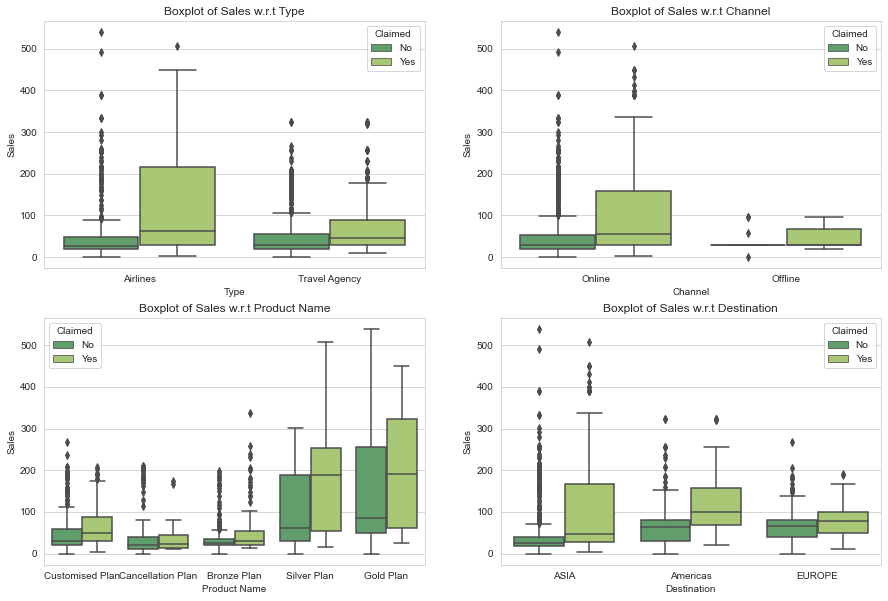

In [980]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.boxplot(y='Sales', x='Type', hue='Claimed', data=df, palette='summer')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Sales w.r.t Type')

plt.subplot(2,2,2)
sns.boxplot(y='Sales', x='Channel', hue='Claimed', data=df, palette='summer')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Sales w.r.t Channel')

plt.subplot(2,2,3)
sns.boxplot(y='Sales', x='Product Name', hue='Claimed', data=df, palette='summer')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Sales w.r.t Product Name');

plt.subplot(2,2,4)
sns.boxplot(y='Sales', x='Destination', hue='Claimed', data=df, palette='summer')
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.title('Boxplot of Sales w.r.t Destination');

#### Pairplot

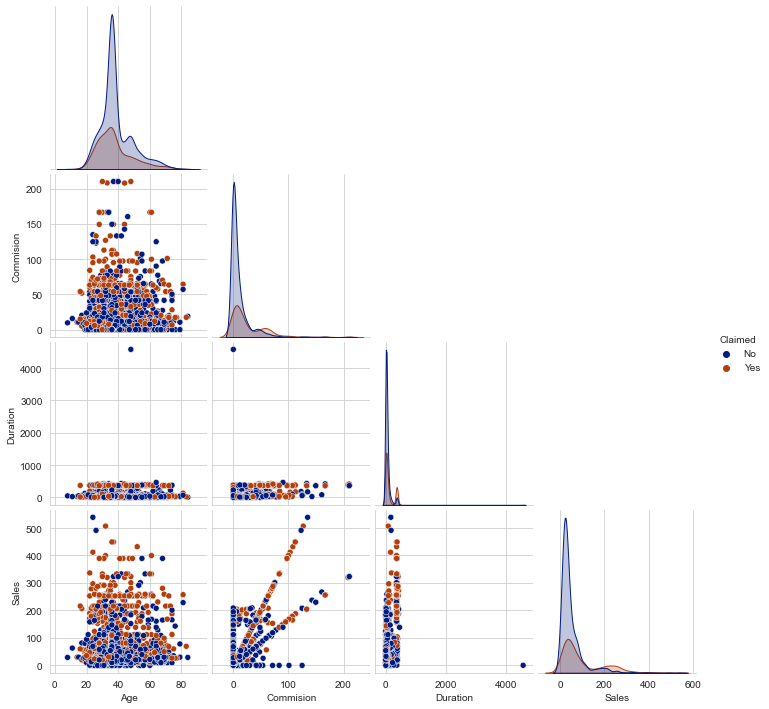

In [981]:
sns.pairplot(df, corner=True, hue='Claimed', palette='dark');

In [982]:
corr = df.corr()
corr

,Age,Commision,Duration,Sales
Age,1.000000,0.064759,0.027226,0.036187
Commision,0.064759,1.000000,0.462073,0.762181
Duration,0.027226,0.462073,1.000000,0.549802
Sales,0.036187,0.762181,0.549802,1.000000


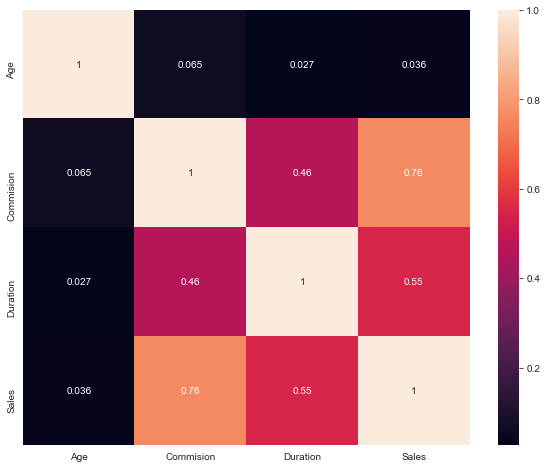

In [983]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True);

In [984]:
df['Agency_Code'].value_counts()

EPX    1238
C2B     913
CWT     471
JZI     239
Name: Agency_Code, dtype: int64

#### 2.2 Data Split: Split the data into test and train(1 pts), build classification model CART (1.5 pts), Random Forest (1.5 pts), Artificial Neural Network(1.5 pts). Object data should be converted into categorical/numerical data to fit in the models. (pd.categorical().codes(), pd.get_dummies(drop_first=True)) Data split, ratio defined for the split, train-test split should be discussed. Any reasonable split is acceptable. Use of random state is mandatory. Successful implementation of each model. Logical reason behind the selection of different values for the parameters involved in each model. Apply grid search for each model and make models on best_params. Feature importance for each model.

#### 2.3 Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy (1 pts), Confusion Matrix (2 pts), Plot ROC curve and get ROC_AUC score for each model (2 pts), Make classification reports for each model. Write inferences on each model (2 pts). Calculate Train and Test Accuracies for each model. Comment on the validness of models (overfitting or underfitting) Build confusion matrix for each model. Comment on the positive class in hand. Must clearly show obs/pred in row/col Plot roc_curve for each model. Calculate roc_auc_score for each model. Comment on the above calculated scores and plots. Build classification reports for each model. Comment on f1 score, precision and recall, which one is important here.

In [985]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = pd.Categorical(df[column]).codes

In [986]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   int64  
 1   Agency_Code   2861 non-null   int8   
 2   Type          2861 non-null   int8   
 3   Claimed       2861 non-null   int8   
 4   Commision     2861 non-null   float64
 5   Channel       2861 non-null   int8   
 6   Duration      2861 non-null   float64
 7   Sales         2861 non-null   float64
 8   Product Name  2861 non-null   int8   
 9   Destination   2861 non-null   int8   
dtypes: float64(3), int64(1), int8(6)
memory usage: 193.1 KB


In [987]:
df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0,0.70,1,7.0,2.51,2,0
1,36,2,1,0,0.00,1,34.0,20.00,2,0
2,39,1,1,0,5.94,1,3.0,9.90,2,1
3,36,2,1,0,0.00,1,4.0,26.00,1,0
4,33,3,0,0,6.30,1,53.0,18.00,0,0


In [988]:
df_categorical['Claimed'].value_counts()

No     1947
Yes     914
Name: Claimed, dtype: int64

In [989]:
# Let us check the proportion of our target variable
# Claimed "No" = 0
# Claimed "Yes" = 1
df['Claimed'].value_counts(normalize=True)

0    0.680531
1    0.319469
Name: Claimed, dtype: float64

### Building CART / Decision Tree Model

#### Extracting the target column into separate vectors for training set and test set

In [990]:
X = df.drop('Claimed', axis=1)

y = df.pop('Claimed')

X.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0.70,1,7.0,2.51,2,0
1,36,2,1,0.00,1,34.0,20.00,2,0
2,39,1,1,5.94,1,3.0,9.90,2,1
3,36,2,1,0.00,1,4.0,26.00,1,0
4,33,3,0,6.30,1,53.0,18.00,0,0


#### Splitting data into training and test set

In [991]:
from sklearn.model_selection import train_test_split

In [992]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

#### Checking the dimensions of the training and test data

In [993]:
df.shape

(2861, 9)

In [994]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (2002, 9)
X_test: (859, 9)
y_train: (2002,)
y_test: (859,)


#### Decision Tree Classifier Model

In [995]:
from sklearn.tree import DecisionTreeClassifier

In [996]:
dtree_model = DecisionTreeClassifier(criterion='gini', random_state=0)

In [997]:
dtree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [998]:
from sklearn import tree

In [999]:
train_char_label = ['No', 'Yes']
tree_file = open('D:\decision_tree.dot','w')
dot_data = tree.export_graphviz(dtree_model, out_file=tree_file, feature_names=list(X_train), class_names=train_char_label)

In [1000]:
tree_file.close()

http://webgraphviz.com/

In [1001]:
from sklearn.model_selection import GridSearchCV

In [1002]:
param_grid = {
    'max_depth': [10,13,15],
    'min_samples_leaf': [10,50,100],
    'min_samples_split': [100,150,200]
}

In [1003]:
reg_dtree = DecisionTreeClassifier()

In [1004]:
grid_search = GridSearchCV(estimator=reg_dtree, param_grid=param_grid, cv=3, scoring='recall')

In [1005]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 13, 15],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [100, 150, 200]},
             scoring='recall')

In [1006]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 150}

In [1007]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=150)

In [1008]:
best_grid = grid_search.best_estimator_

In [1009]:
best_grid.feature_importances_

array([0.01888435, 0.60924483, 0.        , 0.02937268, 0.        ,
       0.02069592, 0.28795869, 0.03384353, 0.        ])

#### Predicting on Training and Test data

In [1010]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

#### Feature Importance

In [1011]:
print (pd.DataFrame(best_grid.feature_importances_, 
                    columns = ["Importance"], index = X_train.columns).sort_values('Importance',ascending=False))

              Importance
Agency_Code     0.609245
Sales           0.287959
Product Name    0.033844
Commision       0.029373
Duration        0.020696
Age             0.018884
Type            0.000000
Channel         0.000000
Destination     0.000000


### Model Evaluation - CART

#### AUC and ROC for Training data

In [1012]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

AUC: 0.83


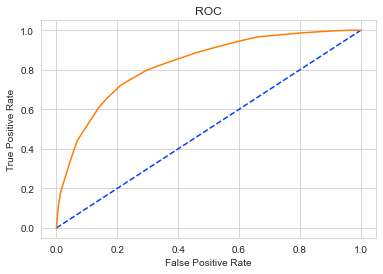

In [1013]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_train_auc = roc_auc_score(y_train, probs)
print('AUC: %.2f' % cart_train_auc)
# calculate roc curve
cart_train_fpr, cart_train_tpr, thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
# plot the roc curve for the model
plt.plot(cart_train_fpr, cart_train_tpr);

#### AUC and ROC for Testing data

AUC: 0.78


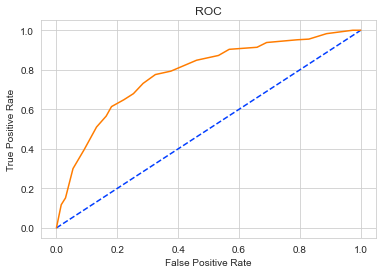

In [1014]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_test_auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % cart_test_auc)
# calculate roc curve
cart_test_fpr, cart_test_tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
# plot the roc curve for the model
plt.plot(cart_test_fpr, cart_test_tpr);

#### Confusion Matrix and Classification Report for Training Data - CART

In [1015]:
print(confusion_matrix(y_train, ytrain_predict))

[[1186  192]
 [ 244  380]]


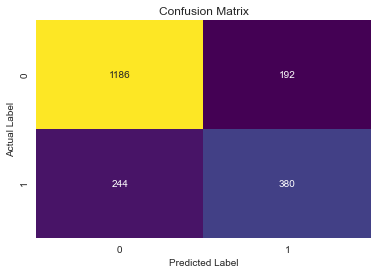

In [1016]:
# Get the confusion matrix on the train data
confusion_matrix(y_train, ytrain_predict)
sns.heatmap(confusion_matrix(y_train, ytrain_predict),annot=True, fmt='d',cbar=False, cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [1017]:
#Train Data Accuracy
cart_train_accuracy = best_grid.score(X_train,y_train) 
cart_train_accuracy

0.7822177822177823

In [1018]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1378
           1       0.66      0.61      0.64       624

    accuracy                           0.78      2002
   macro avg       0.75      0.73      0.74      2002
weighted avg       0.78      0.78      0.78      2002



#### Confusion Matrix and Classification Report for Testing data

In [1019]:
print(confusion_matrix(y_test, ytest_predict))

[[476  93]
 [126 164]]


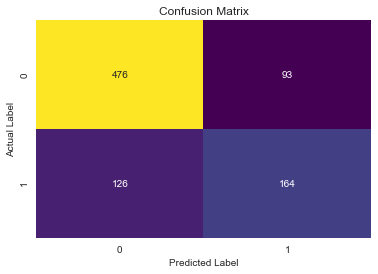

In [1020]:
# Get the confusion matrix on the test data
confusion_matrix(y_test, ytest_predict)
sns.heatmap(confusion_matrix(y_test, ytest_predict),annot=True, fmt='d',cbar=False, cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [1021]:
# Test Data Accuracy
cart_test_accuracy = best_grid.score(X_test, y_test) 
cart_test_accuracy

0.7450523864959255

In [1022]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       569
           1       0.64      0.57      0.60       290

    accuracy                           0.75       859
   macro avg       0.71      0.70      0.71       859
weighted avg       0.74      0.75      0.74       859



In [1024]:
cart_metrics = classification_report(y_train, ytrain_predict,output_dict=True)
dfcart = pd.DataFrame(cart_metrics).transpose()
cart_train_f1 = round(dfcart.loc["1"][2],2)
cart_train_recall = round(dfcart.loc["1"][1],2)
cart_train_precision = round(dfcart.loc["1"][0],2)
print ('cart_train_precision ',cart_train_precision)
print ('cart_train_recall ',cart_train_recall)
print ('cart_train_f1 ',cart_train_f1)

cart_train_precision  0.66
cart_train_recall  0.61
cart_train_f1  0.64


In [1059]:
cart_metrics = classification_report(y_test, ytest_predict, output_dict=True)
dfcart = pd.DataFrame(cart_metrics).transpose()
cart_test_precision = round(dfcart.loc["1"][0],2)
cart_test_recall = round(dfcart.loc["1"][1],2)
cart_test_f1 = round(dfcart.loc["1"][2],2)
print ('cart_test_precision ',cart_test_precision)
print ('cart_test_recall ',cart_test_recall)
print ('cart_test_f1 ',cart_test_f1)

cart_test_precision  0.68
cart_test_recall  0.56
cart_test_f1  0.61


### Conclusion for CART Model

<b>Train Data:</b>  
    AUC: 83%        
    Accuracy: 78%             
    Precision: 66%        
    f1-Score: 64%       
            
<b>Test Data:</b>      
    AUC: 78%      
    Accuracy: 75%         
    Precision: 64%       
    f1-Score: 60%     
  
Training and Test set results are almost similar, and with the overall measures high, the model is a good model.  
  
Agency_Code is the most important variable for predicting claim status. Decision Tree root node split has been done based on Agency_Code. 

### Building Random Forest Model

In [1060]:
from sklearn.ensemble import RandomForestClassifier

In [1061]:
param_grid_rfcl = {
    'max_depth': [10],## 20,30,40
    'max_features': [5],## 7,8,9
    'min_samples_leaf': [10],## 50,100
    'min_samples_split': [100], ## 60,70
    'n_estimators': [201] ## 100,200
}

rfcl = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid_rfcl, cv = 3, scoring='recall')

In [1062]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [10], 'max_features': [5],
                         'min_samples_leaf': [10], 'min_samples_split': [100],
                         'n_estimators': [201]},
             scoring='recall')

In [1063]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 100,
 'n_estimators': 201}

In [1064]:
best_grid = grid_search.best_estimator_

In [1065]:
best_grid

RandomForestClassifier(max_depth=10, max_features=5, min_samples_leaf=10,
                       min_samples_split=100, n_estimators=201, random_state=1)

In [1066]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

#### Feature Importance

In [1067]:
print (pd.DataFrame(best_grid.feature_importances_, 
                    columns = ["Importance"], index = X_train.columns).sort_values('Importance',ascending=False))

              Importance
Agency_Code     0.336628
Product Name    0.233926
Sales           0.196594
Commision       0.096290
Duration        0.067932
Age             0.036288
Type            0.021281
Destination     0.009234
Channel         0.001826


### Model Evaluation - Random Forest

#### AUC and ROC for Training data - Random Forest

AUC: 0.85


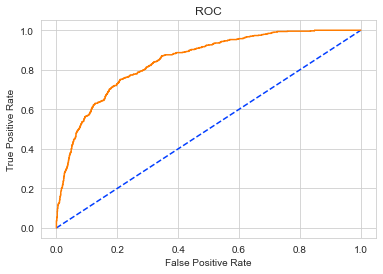

In [1068]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf_train_auc = roc_auc_score(y_train, probs)
print('AUC: %.2f' % rf_train_auc)
# calculate roc curve
rf_train_fpr, rf_train_tpr, thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
# plot the roc curve for the model
plt.plot(rf_train_fpr, rf_train_tpr);

#### AUC and ROC for Testing data - Random Forest

AUC: 0.85


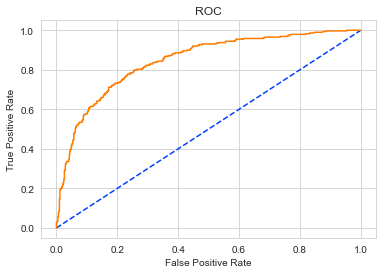

In [1069]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf_test_auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % rf_test_auc)
# calculate roc curve
rf_test_fpr, rf_test_tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
# plot the roc curve for the model
plt.plot(rf_test_fpr, rf_test_tpr);

#### Confusion Matrix and Classification Report for Training Data - Random Forest

In [1070]:
print(confusion_matrix(y_train, ytrain_predict))

[[1297  167]
 [ 260  376]]


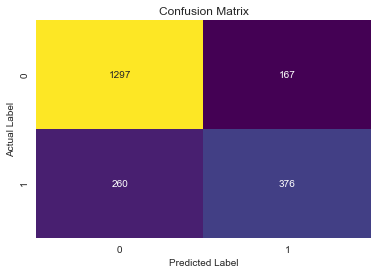

In [1071]:
# Get the confusion matrix on the train data
confusion_matrix(y_train, ytrain_predict)
sns.heatmap(confusion_matrix(y_train, ytrain_predict),annot=True, fmt='d',cbar=False, cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [1072]:
#Train Data Accuracy
rf_train_accuracy = best_grid.score(X_train,y_train) 
rf_train_accuracy

0.7966666666666666

In [1073]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1464
           1       0.69      0.59      0.64       636

    accuracy                           0.80      2100
   macro avg       0.76      0.74      0.75      2100
weighted avg       0.79      0.80      0.79      2100



#### Confusion Matrix and Classification Report for Testing data - Random Forest

In [1074]:
print(confusion_matrix(y_test, ytest_predict))

[[549  63]
 [118 170]]


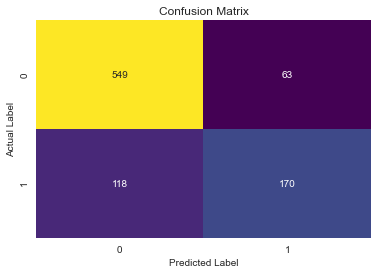

In [1075]:
# Get the confusion matrix on the test data
confusion_matrix(y_test, ytest_predict)
sns.heatmap(confusion_matrix(y_test, ytest_predict),annot=True, fmt='d',cbar=False, cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [1076]:
# Test Data Accuracy
rf_test_accuracy = best_grid.score(X_test, y_test) 
rf_test_accuracy

0.7988888888888889

In [1077]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       612
           1       0.73      0.59      0.65       288

    accuracy                           0.80       900
   macro avg       0.78      0.74      0.76       900
weighted avg       0.79      0.80      0.79       900



In [1078]:
rf_metrics = classification_report(y_train, ytrain_predict,output_dict=True)
dfrf = pd.DataFrame(rf_metrics).transpose()
rf_train_precision = round(dfrf.loc["1"][0],2)
rf_train_recall = round(dfrf.loc["1"][1],2)
rf_train_f1 = round(dfrf.loc["1"][2],2)
print ('rf_train_precision ',rf_train_precision)
print ('rf_train_recall ',rf_train_recall)
print ('rf_train_f1 ',rf_train_f1)

rf_train_precision  0.69
rf_train_recall  0.59
rf_train_f1  0.64


In [1079]:
rf_metrics = classification_report(y_test, ytest_predict,output_dict=True)
dfrf = pd.DataFrame(rf_metrics).transpose()
rf_test_precision = round(dfrf.loc["1"][0],2)
rf_test_recall = round(dfrf.loc["1"][1],2)
rf_test_f1 = round(dfrf.loc["1"][2],2)
print ('rf_test_precision ',rf_test_precision)
print ('rf_test_recall ',rf_test_recall)
print ('rf_test_f1 ',rf_test_f1)

rf_test_precision  0.73
rf_test_recall  0.59
rf_test_f1  0.65


### Conclusion for Random Forest Model

<b>Train Data:</b>  
    AUC: 85%        
    Accuracy: 80%             
    Precision: 69%        
    f1-Score: 64%       
            
<b>Test Data:</b>      
    AUC: 80%      
    Accuracy: 80%         
    Precision: 73%       
    f1-Score: 65%     
  
Training and Test set results are almost similar, and with the overall measures high, the model is a good model.  
  
Agency_Code is the most important variable for predicting claim status. 

### Building Neural Network Model

In [1080]:
from sklearn.neural_network import MLPClassifier

In [1081]:
from sklearn.preprocessing import StandardScaler

In [1082]:
df1 = pd.read_csv('insurance_part2_data-2.csv')
df1.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [1083]:
for column in df1.columns:
    if df1[column].dtype == 'object':
        df1[column] = pd.Categorical(df1[column]).codes

In [1084]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   int8   
 2   Type          3000 non-null   int8   
 3   Claimed       3000 non-null   int8   
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   int8   
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   int8   
 9   Destination   3000 non-null   int8   
dtypes: float64(2), int64(2), int8(6)
memory usage: 111.5 KB


In [1085]:
X = df1.drop('Claimed', axis=1)

y = df1.pop('Claimed')

X.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0.70,1,7,2.51,2,0
1,36,2,1,0.00,1,34,20.00,2,0
2,39,1,1,5.94,1,3,9.90,2,1
3,36,2,1,0.00,1,4,26.00,1,0
4,33,3,0,6.30,1,53,18.00,0,0


In [1086]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [1087]:
sc = StandardScaler()

In [1088]:
sc.fit_transform(X_train)

array([[-0.19416819,  0.7047513 ,  0.79799046, ...,  0.09168619,
        -0.53443162,  3.03459053],
       [ 0.18753385,  1.71085446, -1.25314781, ..., -0.00417853,
        -1.32478824,  3.03459053],
       [ 0.85551243, -1.307455  , -1.25314781, ...,  2.62319957,
         1.83663824, -0.43634635],
       ...,
       [-0.48044473,  1.71085446, -1.25314781, ..., -0.53828197,
        -1.32478824, -0.43634635],
       [-0.19416819,  0.7047513 ,  0.79799046, ..., -0.83957109,
        -0.53443162, -0.43634635],
       [-1.33927433,  0.7047513 ,  0.79799046, ..., -0.46980717,
         0.255925  , -0.43634635]])

In [1089]:
sc.transform(X_test)

array([[-0.19416819,  0.7047513 ,  0.79799046, ..., -0.48350213,
        -0.53443162, -0.43634635],
       [-0.95757228, -1.307455  , -1.25314781, ...,  0.70111192,
         1.83663824, -0.43634635],
       [ 0.09210834,  1.71085446, -1.25314781, ..., -0.53828197,
        -1.32478824, -0.43634635],
       ...,
       [-0.09874268,  1.71085446, -1.25314781, ..., -0.59306181,
        -1.32478824, -0.43634635],
       [-0.19416819,  0.7047513 ,  0.79799046, ..., -0.45611221,
         0.255925  , -0.43634635],
       [ 1.90519305, -1.307455  , -1.25314781, ..., -0.62045173,
        -1.32478824, -0.43634635]])

In [1090]:
param_grid = {
    'hidden_layer_sizes': [3,5,7], # 50, 200
    'max_iter': [2500], #5000,2500
    'solver': ['adam','sgd', 'lbfgs'], #sgd
    'tol': [0.01, 0.001], 
}

nncl = MLPClassifier(random_state=0)

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 5, scoring='recall')

In [1091]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=0),
             param_grid={'hidden_layer_sizes': [3, 5, 7], 'max_iter': [2500],
                         'solver': ['adam', 'sgd', 'lbfgs'],
                         'tol': [0.01, 0.001]},
             scoring='recall')

In [1092]:
grid_search.best_params_

{'hidden_layer_sizes': 7, 'max_iter': 2500, 'solver': 'lbfgs', 'tol': 0.01}

In [1093]:
grid_search.best_estimator_

MLPClassifier(hidden_layer_sizes=7, max_iter=2500, random_state=0,
              solver='lbfgs', tol=0.01)

In [1094]:
best_grid = grid_search.best_estimator_

In [1095]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

### Model Evaluation

#### Confusion Matrix and Classification Report for Training data - ANN

In [1096]:
print(confusion_matrix(y_train, ytrain_predict))

[[1266  198]
 [ 271  365]]


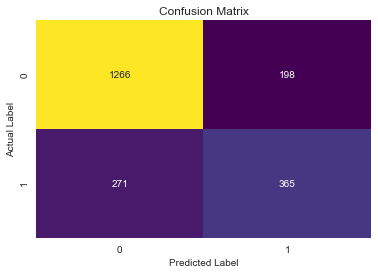

In [1097]:
# Get the confusion matrix on the train data
confusion_matrix(y_train, ytrain_predict)
sns.heatmap(confusion_matrix(y_train, ytrain_predict),annot=True, fmt='d',cbar=False, cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [1098]:
#Train Data Accuracy
nn_train_accuracy = best_grid.score(X_train,y_train) 
nn_train_accuracy

0.7766666666666666

In [1099]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1464
           1       0.65      0.57      0.61       636

    accuracy                           0.78      2100
   macro avg       0.74      0.72      0.73      2100
weighted avg       0.77      0.78      0.77      2100



#### Confusion Matrix and Classification Report for Testing data - ANN

In [1100]:
print(confusion_matrix(y_test, ytest_predict))

[[537  75]
 [128 160]]


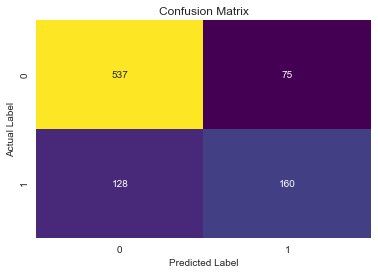

In [1101]:
# Get the confusion matrix on the train data
confusion_matrix(y_test, ytest_predict)
sns.heatmap(confusion_matrix(y_test, ytest_predict),annot=True, fmt='d',cbar=False, cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [1102]:
#Test Data Accuracy
nn_test_accuracy = best_grid.score(X_test,y_test) 
nn_test_accuracy

0.7744444444444445

In [1103]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       612
           1       0.68      0.56      0.61       288

    accuracy                           0.77       900
   macro avg       0.74      0.72      0.73       900
weighted avg       0.77      0.77      0.77       900



### Model Evaluation - ANN

#### AOC and ROC for Training data - ANN

AUC: 0.81


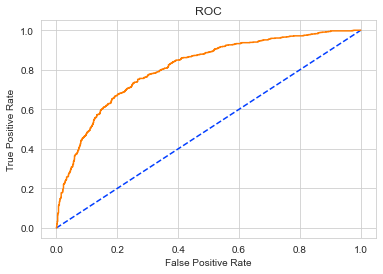

In [1104]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
nn_train_auc = roc_auc_score(y_train, probs)
print('AUC: %.2f' % nn_train_auc)
# calculate roc curve
nn_train_fpr, nn_train_tpr, thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
# plot the roc curve for the model
plt.plot(nn_train_fpr, nn_train_tpr);

#### AOC and ROC for Testing data - ANN

AUC: 0.83


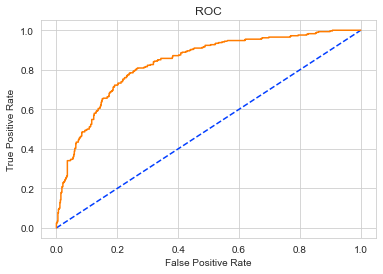

In [1105]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
nn_test_auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % nn_test_auc)
# calculate roc curve
nn_test_fpr, nn_test_tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
# plot the roc curve for the model
plt.plot(nn_test_fpr, nn_test_tpr);

In [1106]:
nn_metrics = classification_report(y_train, ytrain_predict,output_dict=True)
dfnn = pd.DataFrame(nn_metrics).transpose()
nn_train_precision = round(dfnn.loc["1"][0],2)
nn_train_recall = round(dfnn.loc["1"][1],2)
nn_train_f1 = round(dfnn.loc["1"][2],2)
print ('nn_train_precision ',nn_train_precision)
print ('nn_train_recall ',nn_train_recall)
print ('nn_train_f1 ',nn_train_f1)

nn_train_precision  0.65
nn_train_recall  0.57
nn_train_f1  0.61


In [1107]:
nn_metrics = classification_report(y_test, ytest_predict,output_dict=True)
dfnn = pd.DataFrame(nn_metrics).transpose()
nn_test_precision = round(dfnn.loc["1"][0],2)
nn_test_recall = round(dfnn.loc["1"][1],2)
nn_test_f1 = round(dfnn.loc["1"][2],2)
print ('nn_test_precision ',nn_test_precision)
print ('nn_test_recall ',nn_test_recall)
print ('nn_test_f1 ',nn_test_f1)

nn_test_precision  0.68
nn_test_recall  0.56
nn_test_f1  0.61


### Conclusion for Artificial Neural Network (ANN)

<b>Train Data:</b>  
    AUC: 81%        
    Accuracy: 78%             
    Precision: 65%        
    f1-Score: 61%       
            
<b>Test Data:</b>      
    AUC: 83%      
    Accuracy: 77%         
    Precision: 68%       
    f1-Score: 61%     
  
The ANN model seems to over-fit.   

#### 2.4 Final Model - Compare all models on the basis of the performance metrics in a structured tabular manner (2.5 pts). Describe on which model is best/optimized (1.5 pts ). A table containing all the values of accuracies, precision, recall, auc_roc_score, f1 score. Comparison between the different models(final) on the basis of above table values. After comparison which model suits the best for the problem in hand on the basis of different measures. Comment on the final model.

#### Comparison of the performance metrics from the 3 models

In [1108]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'CART Train':[cart_train_accuracy,cart_train_auc,cart_train_recall,cart_train_precision,cart_train_f1],
        'CART Test':[cart_test_accuracy,cart_test_auc,cart_test_recall,cart_test_precision,cart_test_f1],
       'Random Forest Train':[rf_train_accuracy,rf_train_auc,rf_train_recall,rf_train_precision,rf_train_f1],
        'Random Forest Test':[rf_test_accuracy,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1],
       'Neural Network Train':[nn_train_accuracy,nn_train_auc,nn_train_recall,nn_train_precision,nn_train_f1],
        'Neural Network Test':[nn_test_accuracy,nn_test_auc,nn_test_recall,nn_test_precision,nn_test_f1]},index=index)
round(data,2)

,CART Train,CART Test,Random Forest Train,Random Forest Test,Neural Network Train,Neural Network Test
Accuracy,0.78,0.75,0.80,0.80,0.78,0.77
AUC,0.83,0.78,0.85,0.85,0.81,0.83
Recall,0.61,0.56,0.59,0.59,0.57,0.56
Precision,0.66,0.68,0.69,0.73,0.65,0.68
F1 Score,0.64,0.61,0.64,0.65,0.61,0.61


#### ROC Curve for the 3 models on the Training data

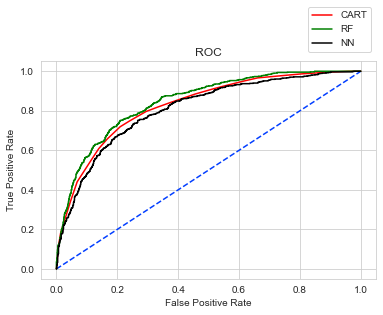

In [1109]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_train_fpr, cart_train_tpr,color='red',label="CART")
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label="RF")
plt.plot(nn_train_fpr,nn_train_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right');

#### ROC Curve for the 3 models on the Testing data

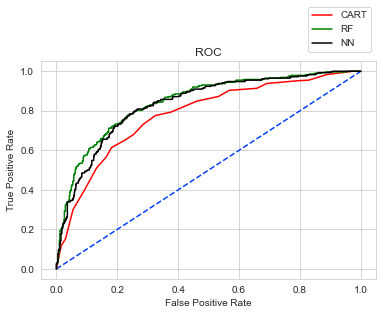

In [1110]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_test_fpr, cart_test_tpr,color='red',label="CART")
plt.plot(rf_test_fpr,rf_test_tpr,color='green',label="RF")
plt.plot(nn_test_fpr,nn_test_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right');

Out of the 3 models, Random Forest has slightly better performance than the CART and ANN model. 

Overall all the 3 models are reasonably stable enough to be used for making any future predictions. From CART and Random Forest Model, the variable Agency_Code is found to be the most useful feature amongst all other features for predicting if a customer has claimed the insurance or not. 

-----HAPPY LEARNING-----